In [28]:
# Copyright 2024 Stephan Bscheider sbsch@bu.edu
# Copyright 2024 Humzah Durrani hhd8@bu.edu
# Copyright 2024 Alex Tianji Sun tianjis@bu.edu

###
import json
import pandas as pd
import random
import numpy as np
import re
from operator import itemgetter
import matplotlib.pyplot as plt

dataframe = pd.DataFrame

with open("student_information.json", 'r') as file:
    dataDict = json.load(file)
    
gpaDict = dict(dataDict['GPA'])
statusDict = dict(dataDict['status'])
distParamfull = re.findall(r'\((.*?)\)',gpaDict['dist'])
distParam = re.split(',',distParamfull[0])
distRange = list(gpaDict['range'])
idDict = dict(dataDict['student_id'])
statusList = list(dataDict['status'])

columnsS = list(dataDict)
columnsS = columnsS[1:]
dist = gpaDict['dist']

status = []

database = pd.DataFrame
database = database(index=range(dataDict['number']),columns=list(columnsS))

## This way uses the .apply method, to iterate through each row of the dataframe and call the generate_student_data function
## to generate the names, gpas, ect for each row at a time as oppose to the list method, no for loops used here.    
def generate_student_data(row):
    first_name = random.choice(dataDict['first_names'])
    last_name = random.choice(dataDict['last_names'])
    gpa = round(random.gauss(float(distParam[0]), float(distParam[1])), 1)
    student_id = idDict['prefix'] + str(np.random.choice(range(int(idDict['min']), int(idDict['max'])), replace=False))
    statusOdds = random.randrange(1, 10)
    if statusOdds < float(statusList[0][0]) * 10:
        status = statusList[0][1] 
    else:
        status = statusList[1][1]
        
    return pd.Series([first_name, last_name, gpa, student_id, status])

# Apply the function to each row
database[['first_names', 'last_names', 'GPA', 'student_id', 'status']] = database.apply(generate_student_data, axis=1)
database['GPA'] = database['GPA'].clip(distRange[0], distRange[1])

#print(database)
database.to_csv('student_information.csv')

## Food for though, this cell took 5 full seconds to run? That can't be good, not sure exactly why it's so slow.

In [29]:
student_info = pd.read_csv('student_information.csv')
student_info = student_info.sort_values(by='GPA', ascending=False)
student_info.reset_index(drop=True,inplace=True)

with open("assessment_information.json", 'r') as file:
        dataDict = json.load(file)

assignments = list(dataDict.keys()) 

def distribution(status, key, row, size, sortedDists, i):
    
    ####
    ## This theoretically creates the Grades for each student, but right now its not using the multiple distributions
    ## correctly, the bug is it is only using the last distribution for all of the student and not breaking it
    ## up correctly
    ####
    weightEnrolled = dataDict[key]['completes'][0]
    weightDropped = dataDict[key]['completes'][1]
    lbound = dataDict[key]['range'][0]
    ubound = dataDict[key]['range'][1]

    if status == 'Enrolled':
        if random.random() < weightEnrolled:
                mean_grade = sortedDists[i][1]
                variance = sortedDists[i][2]
                grades = random.gauss(mean_grade, variance)
                grades = np.clip(grades, lbound, ubound)
        else:
            grades = 0
    else:
        if random.random() < weightDropped:
                mean_grade = sortedDists[i][1]
                variance = sortedDists[i][2]
                grades = random.gauss(mean_grade, variance)
                grades = np.clip(grades, lbound, ubound)
        else:
            grades = 0
            
    return grades                

def process_key(key):
    ####
    ## Using this function to go through the assignment categories and create a dataframe for each
    ####
    count = int(dataDict[key]['count'])
    columns = list(map(lambda x: f"{key} {x+1}", range(count)))
    frame = pd.DataFrame(index=student_info.index, columns=columns)
    score = pd.DataFrame()
    tempFrame2 = pd.DataFrame(index=student_info.index, columns=columns)
    
    dists = list(dataDict[key]['grades'])
    sortedDists = sorted(dists, key=itemgetter(1),reverse=True)
    size = [0,0]
    
    # Splits the students into groups based on the different distributions in student_information.json
    # and runs them through the distribution function to create random grades for each individual assignment
    for i in range(len(sortedDists)):
        size = [size[1],size[1] + int(float(sortedDists[i][0])*100)]
        tempFrame = student_info.iloc[size[0]:size[1]]

        for col in columns:
            tempFrame2[col] = tempFrame.apply(lambda row: distribution(row['status'], key, row, size[1], sortedDists, i), axis=1)

        frame = frame.combine_first(tempFrame2)
        frame.set_index(student_info['student_id'])
        
    # Checking the weighted total of the assignment types and if theres only one turning it into a list
    if type(dataDict[key]['total']) == int:
        totList = [dataDict[key]['total']]
    else:
        totList = dataDict[key]['total']
    
    # Summing the scores for each assignement and applying the weight
    for i in range(len(totList)):
        if len(totList) < 2:
            frame[f'{key} Score'] = frame.sum(axis=1)
            frame['Max Score'] = count*100
            score[f'{key} Score'] = frame[f'{key} Score'] / frame['Max Score'] * (totList[i] / 100)
        else:
            score[f"{key} {i+1} Score"] = (
                frame[f"{key} {i+1}"] / 100 ) * (totList[i] / 100)
            
        #print(score)
        
    frame.to_csv(f'{key}frame.csv')
    return score

# Use map to iterate over the keys
# This is from way back when we were actually trying to do the no for loop challenge
assignments = list(map(process_key, dataDict.keys()))


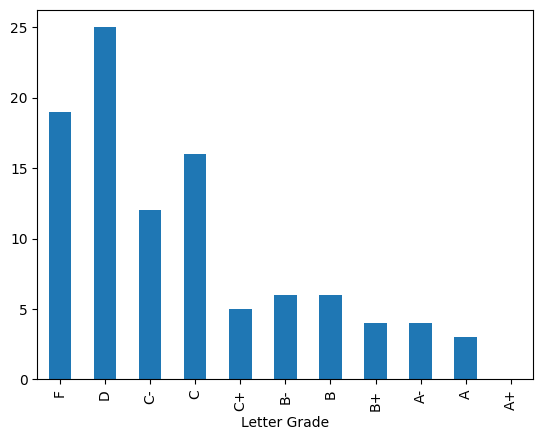

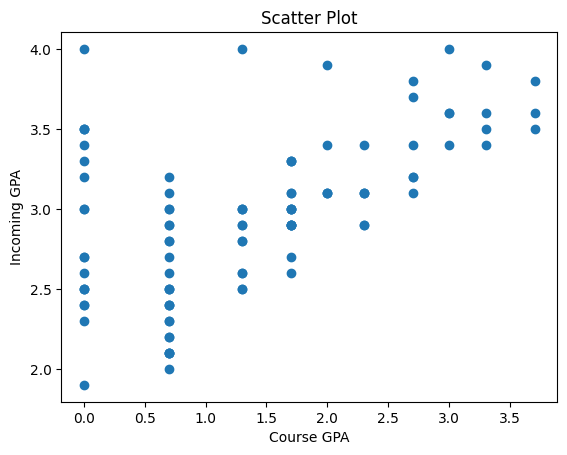

In [30]:
# Taking in the weighted scored from the last cell we now post process the information, to assign letter grades and visualize the data

final_grade = pd.DataFrame(student_info['student_id'])

for i in range(len(assignments)):
        final_grade = pd.merge(final_grade, assignments[i], left_index = True, right_index = True)

# Summing all the weighted totals from each assignment type to get the final course number grade
final_grade = final_grade.drop('student_id', axis=1)
final_grade['Course Grade'] = (final_grade.sum(axis=1))*100

# Seperating students into bins based on number grade to assign letter grades
final_grade['Letter Grade'] = pd.cut(final_grade['Course Grade'],
                                     bins=[0,60,70,73,77,80,83,87,90,93,96,100],
                                     labels=['F','D','C-','C','C+','B-','B',
                                              'B+','A-','A','A+'])



grade_counts = final_grade["Letter Grade"].value_counts().sort_index()
plt.figure(0)
grade_counts.plot.bar()
final_gpa = pd.DataFrame()
final_gpa['GPA'] = pd.cut(final_grade['Course Grade'], bins=[0,60,70,73,77,80,83,87,90,93,96,100],
                                                      labels=[0,0.7,1.3,1.7,2.0, 
                                                              2.3,2.7,3.0,3.3,3.7,4.0])
plt.figure(1)
plt.scatter(final_gpa['GPA'], student_info['GPA'])
plt.xlabel("Course GPA")
plt.ylabel("Incoming GPA")
plt.title("Scatter Plot")
final_grade.to_csv('student_grades.csv')